# MultiLabel Classification using huggingface and tesnorflow libraries

In [1]:
#Import libraries
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
tf.get_logger().setLevel('ERROR')

## Data Processing

In [2]:
#Reading data to Pandas Dataframes
df_train = pd.read_csv("C:/Users/sreem/Downloads/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv")

label_cols = df_train.columns.tolist()[2:]

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


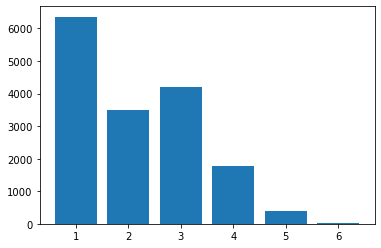

In [3]:
#Plot the number of questions per number of tags for each question
df_train['sum'] = df_train.drop(['id', 'comment_text'], axis=1).sum(axis=1)
df1 = df_train[df_train['sum']>0]
df_train.drop(['sum'], axis = 1, inplace =True)
dic = dict(df1['sum'].value_counts())
dic = dict(sorted(dic.items()))
plt.bar(range(len(dic)), list(dic.values()), align='center')
plt.xticks(range(len(dic)), list(dic.keys()))
plt.show()

### Preprocessing Text

In [4]:
#Import Tokeniser to convert text to tokens
from transformers import BertTokenizer
#pad_sequences is used to pad sentences which have <128 token length.
from tensorflow.keras.preprocessing.sequence import pad_sequences

bert_model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)
MAX_LEN = 128

In [5]:
def tokenize_sentences(sentences, tokenizer):
    tokenized_sentences = []
    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(sentence,add_special_tokens = True, max_length = MAX_LEN)
        tokenized_sentences.append(tokenized_sentence)
    return tokenized_sentences

In [6]:
input_ids = tokenize_sentences(df_train['comment_text'], tokenizer)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

  0%|          | 0/159571 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [7]:
def create_attention_masks(tokenized_and_padded_sentences):
    #Tells the model which tokens to attend to.
    attention_masks = []
    for sentence in tqdm(tokenized_and_padded_sentences):
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)
    return np.asarray(attention_masks)

In [8]:
attention_masks = create_attention_masks(input_ids)

  0%|          | 0/159571 [00:00<?, ?it/s]

In [9]:
y =  df_train[label_cols].values
#Using the same random state makes sure corresponding pairs are chosen
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, y, random_state=0, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, y, random_state=0, test_size=0.1)

train_size = len(train_inputs)
validation_size = len(validation_inputs)

In [10]:
BATCH_SIZE = 16
NR_EPOCHS = 1

#Using tf.data for effeciency
def create_dataset(data_tuple, epochs=1, batch_size=32, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)
    return dataset

train_dataset = create_dataset((train_inputs, train_masks, train_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
validation_dataset = create_dataset((validation_inputs, validation_masks, validation_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)

## Defining the model


In [11]:
from transformers import TFBertModel
from tensorflow.keras.layers import Dense, Flatten

class BertClassifier(tf.keras.Model):    
    def __init__(self, bert: TFBertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = Dense(num_classes, activation='sigmoid')
        
    @tf.function
    def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)
    #Taking the first hidden-state from BERT output (corresponding to CLS token) 
    #and feed it into a Dense layer with 6 neurons
        output = self.classifier(outputs[1])
                
        return output

model = BertClassifier(TFBertModel.from_pretrained(bert_model_name), len(label_cols))

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Training

In [12]:
from transformers import create_optimizer
train_loss_list = []
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = validation_size // BATCH_SIZE

#Loss functions
train_loss = tf.keras.metrics.Mean(name='train_loss')
validation_loss = tf.keras.metrics.Mean(name='test_loss')

#Optimizer (with 1-cycle-policy)
warmup_steps = steps_per_epoch // 3
total_steps = steps_per_epoch * NR_EPOCHS - warmup_steps
optimizer, _ = create_optimizer(init_lr=2e-5, num_train_steps=total_steps, num_warmup_steps=warmup_steps)

#using AUC(area under the curve) per each label
train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]
validation_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]
dic = {}
for label_name in label_cols:
    dic[label_name] = []
    
@tf.function
def train_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(token_ids, attention_mask=masks)
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    for i, auc in enumerate(train_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
        
@tf.function
def validation_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)
    predictions = model(token_ids, attention_mask=masks, training=False)
    v_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(labels, predictions)
    validation_loss(v_loss)
    for i, auc in enumerate(validation_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
                                              
def train(model, train_dataset, val_dataset, train_steps_per_epoch, val_steps_per_epoch, epochs):
    for epoch in range(epochs):
        print("EPOCH ", epoch)

        for i, (token_ids, masks, labels) in enumerate(tqdm(train_dataset, total=train_steps_per_epoch)):
            train_step(model, token_ids, masks, labels)
            if i % 1000 == 0:
                train_loss_list.append(train_loss.result())
                for i, label_name in enumerate(label_cols):
                    dic[label_name].append(train_auc_metrics[i].result().numpy())
                    train_auc_metrics[i].reset_states()
        
        for i, (token_ids, masks, labels) in enumerate(tqdm(val_dataset, total=val_steps_per_epoch)):
            validation_step(model, token_ids, masks, labels)

        print('Validation Loss: {}'.format(validation_loss.result()))

        for i, label_name in enumerate(label_cols):
            print("{} roc_auc {}".format(label_name,validation_auc_metrics[i].result()))

train(model, train_dataset, validation_dataset, steps_per_epoch, validation_steps,NR_EPOCHS)

EPOCH  0


  0%|          | 0/8975 [00:00<?, ?it/s]

  0%|          | 0/997 [00:00<?, ?it/s]

Validation Loss: 0.03706349432468414
toxic roc_auc 0.9881812334060669
severe_toxic roc_auc 0.988361656665802
obscene roc_auc 0.9915918111801147
threat roc_auc 0.9735177159309387
insult roc_auc 0.9871667623519897
identity_hate roc_auc 0.9728728532791138


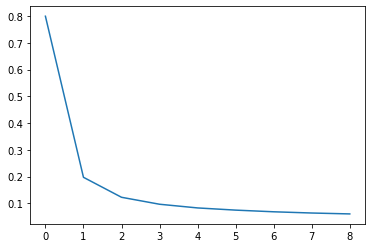

In [13]:
plt.plot(train_loss_list)

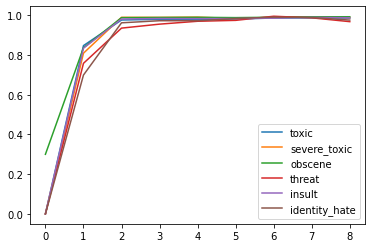

In [14]:
#Plotting the ROC accuracy scores per label 
for key, data_list in dic.items():
    plt.plot(data_list, label=key)
plt.legend()

In [15]:
model.save_weights('model_checkpt', save_format='tf')